In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
from tqdm import tqdm
from config_management.data_config_dijet import DataConfig
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm  # For colormap
from KDEpy import FFTKDE
from scipy.interpolate import RegularGridInterpolator
from config_management.data_config_dijet import DataConfig

In [2]:
# Load dijets samples dataset

file_path = './data/Dijets.csv'
df = pd.read_csv(file_path)
print(df.head())
columns = ['mjj', 'HT']
samples = df[columns].to_numpy()

        # R         mjj          HT      eta1      eta2      phi1      phi2
0  3.806679  136.146906   83.247403  0.877576  3.027273 -2.840138  0.301454
1  4.415298  275.114546  111.625207  0.581774  3.684234  0.984612 -2.156981
2  3.251374   53.375240   49.012233 -1.133021 -0.295270 -0.018955  3.122637
3  4.691516  165.761831   56.334651  2.688435 -0.795919  0.926908 -2.214684
4  3.451928   67.476058   53.262190  0.491303  1.921758  2.827438 -0.314155


In [3]:
# scale mjj and HT between 0 and 1 from original samples dataset
mjj = df["mjj"].to_numpy()
HT = df["HT"].to_numpy()
mjj = (mjj - np.min(mjj)) / (np.max(mjj) - np.min(mjj))
HT = (HT - np.min(HT)) / (np.max(HT) - np.min(HT))

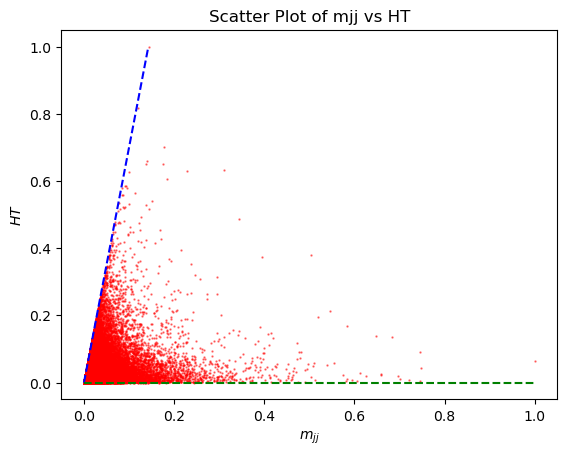

In [4]:
# Scatter plot of the scaled samples

plt.scatter(mjj, HT, s=0.5, alpha=0.5, label='Data Points', color='red')
plt.xlabel(r"$m_{jj}$") # mjj
plt.ylabel(r"$HT$") # HT
plt.title("Scatter Plot of mjj vs HT")
slopev = 7.0
xlv = np.linspace(0, 1/slopev, 100)
ylv = slopev*xlv
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
slopeh = 0.0
xlh = np.linspace(0, 1, 100)
ylh = slopeh*xlh
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')

In [5]:
mjj = mjj.reshape(-1, 1)
HT = HT.reshape(-1, 1)

In [6]:
# Fit kernel density estimate on the scaled covariates
scaled_samples = np.hstack((mjj, HT))
d = scaled_samples.shape[1]
jxbins = 3500j
bw_adj_joint = DataConfig().bw_adj_joint
kernel_type = DataConfig().kernel_type
slices = [slice(-1.1, 1.1, jxbins), slice(-1.1, 1.1, jxbins)]
grids = np.mgrid[tuple(slices)]
grid_coords = np.vstack([[grids[i].ravel()] for i in range(d)]).T
bw = bw_adj_joint * scipy.stats.gaussian_kde(scaled_samples.T).scotts_factor()
kde_all = FFTKDE(bw=bw, kernel=kernel_type)
kde_all.fit(scaled_samples)
zgrid = kde_all.evaluate(grid_coords).reshape(grids[0].shape)
zgrid = np.clip(zgrid, 0, None)  # Ensure non-negative values

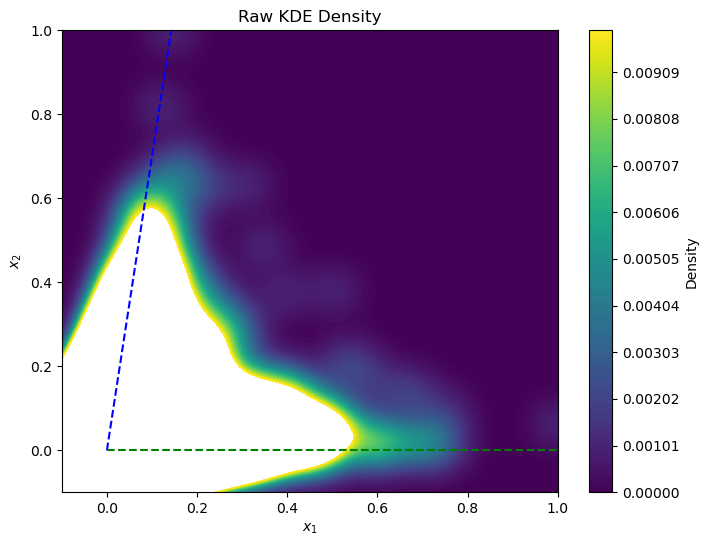

In [7]:
# Raw kernel density estimate

plt.figure(figsize=(8, 6))
vmin, vmax = 0, 0.01#200
levels = np.linspace(vmin, vmax, 100)  # for 30 intervals
plt.contourf(grids[0], grids[1], zgrid, levels=levels, cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel(r"$x_1$") # R
plt.ylabel(r"$x_2$") # mjj
plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)
plt.title(f"Raw KDE Density")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.show()

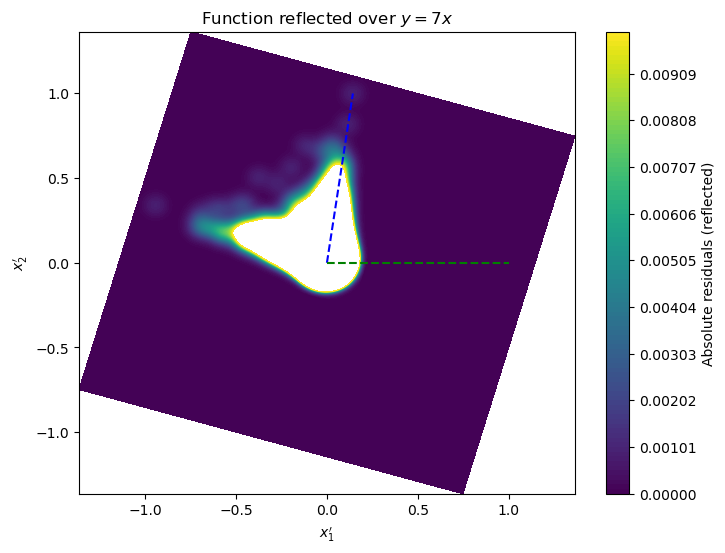

In [8]:
# Reflection trick demo on a hard boundary

# Assume xgrid, ygrid are your meshgrid arrays, zgrid is your function
m = 7

# Flatten the grid for easier computation
x_flat = grids[0].ravel()
y_flat = grids[1].ravel()

# Compute the reflection over y = m*x
d = (x_flat + m * y_flat) / (1 + m**2)
x_ref = 2 * d - x_flat
y_ref = 2 * d * m - y_flat

# Reshape to grid shape
x_ref_grid = x_ref.reshape(grids[0].shape)
y_ref_grid = y_ref.reshape(grids[1].shape)
z_ref_grid = zgrid  # or zgrid if you want signed values

# Plot on the reflected grid
plt.figure(figsize=(8, 6))
plt.contourf(x_ref_grid, y_ref_grid, z_ref_grid, levels=levels, cmap="viridis")

plt.colorbar(label="Absolute residuals (reflected)")
plt.xlabel(r"$x_1'$")
plt.ylabel(r"$x_2'$")
plt.title("Function reflected over $y=7x$")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.show()

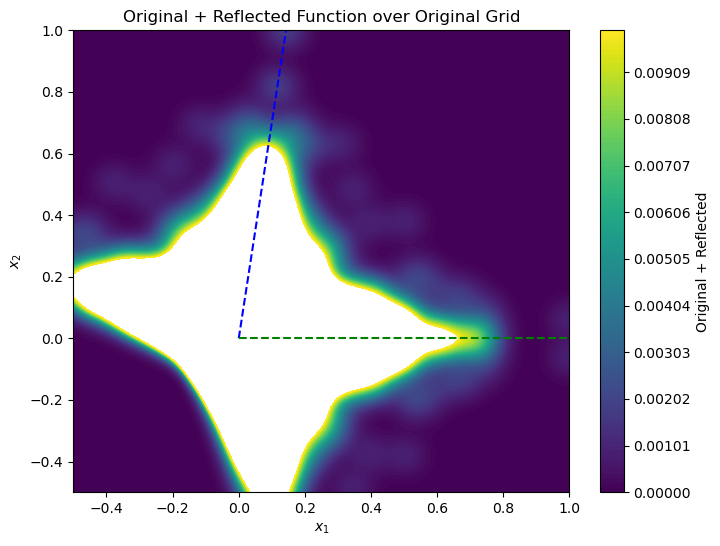

In [9]:
# Corrected KDE using reflection trick

m1 = 7
m2 = 0

# 1. Reflect the original grid points
x_flat1 = grids[0].ravel()
y_flat1 = grids[1].ravel()
d1 = (x_flat1 + m1 * y_flat1) / (1 + m1**2)
x_ref1 = 2 * d1 - x_flat1
y_ref1 = 2 * d1 * m1 - y_flat1

x_flat2 = grids[0].ravel()
y_flat2 = grids[1].ravel()
d2 = (x_flat2 + m2 * y_flat2) / (1 + m2**2)
x_ref2 = 2 * d2 - x_flat2
y_ref2 = 2 * d2 * m2 - y_flat2

# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp1 = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    np.abs(zgrid),            # function values
    bounds_error=False,
    fill_value=0
)

interp2 = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    np.abs(zgrid),            # function values
    bounds_error=False,
    fill_value=0
)


# For each original grid point, get the value of the reflected functions at that location
reflected_vals1 = interp1(np.vstack([x_ref1, y_ref1]).T)
reflected_vals_grid1 = reflected_vals1.reshape(grids[0].shape)

reflected_vals2 = interp2(np.vstack([x_ref2, y_ref2]).T)
reflected_vals_grid2 = reflected_vals2.reshape(grids[0].shape)

# 3. Add the reflected function to the original function
sum_grid = reflected_vals_grid1 + reflected_vals_grid2 + zgrid
mask = (grids[1] > 7 * grids[0]) | (grids[1] < 0)
# sum_grid[mask] = 0
# 4. Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(grids[0], grids[1], sum_grid, levels=levels, cmap="viridis")
plt.colorbar(label="Original + Reflected")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Original + Reflected Function over Original Grid")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)
plt.show()

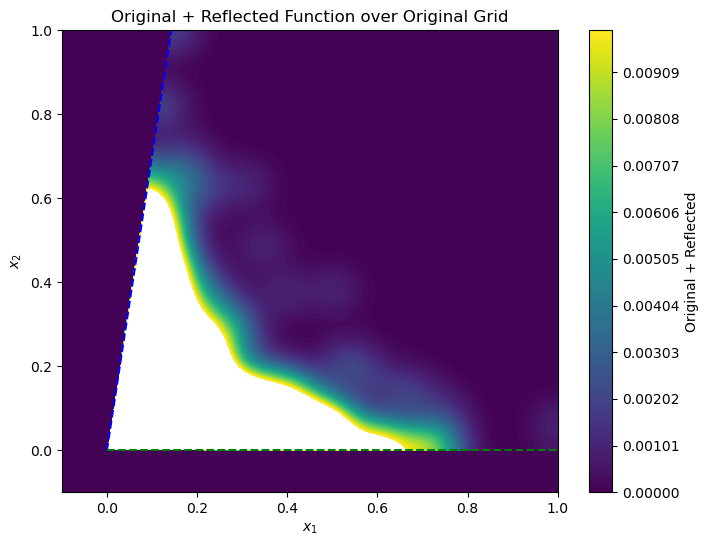

In [10]:
mask = (grids[1] > 7 * grids[0]) | (grids[1] < 0)
sum_grid[mask] = 0
# 4. Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(grids[0], grids[1], sum_grid, levels=levels, cmap="viridis")
plt.colorbar(label="Original + Reflected")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Original + Reflected Function over Original Grid")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)
plt.show()

In [11]:
import numpy as np

# Flatten the grids and sum_grid
x_flat = grids[0].ravel()
y_flat = grids[1].ravel()
sum_flat = sum_grid.ravel()
mask_flat = mask.ravel()

# Select unmasked points
x_unmasked = x_flat[~mask_flat]
y_unmasked = y_flat[~mask_flat]
sum_unmasked = sum_flat[~mask_flat]

# Stack into columns and save as CSV
data = np.column_stack((x_unmasked, y_unmasked, sum_unmasked))
# np.savetxt("./data/processed_data/dijet_joint_data.csv", data, delimiter=",", comments='')

# Residuals

In [12]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

In [13]:
def res_func_complexity_5(x1, x2, mask):
    return np.where(mask, (0.059419669357153496 / x1) / x2, 0)

def res_func_complexity_6(x1, x2, mask):
    return np.where(mask, pow3(0.3686895696283121 / (x1 + x2)), 0)

def res_func_complexity_8(x1, x2, mask):
    return np.where(mask, np.exp(((x1 + x2) + -0.2901637250235071) / -0.04594133847567203), 0)

def res_func_complexity_end(x1, x2, mask):
    return np.where(mask, np.exp(((1.7444606403416665 * (x2 + pow2(-0.10482564710643719 + (x1 + x1)))) + (x1 + -0.4651430951236344)) / -0.04345676323011133) * (pow3(x2 * pow2((x2 + x1) / 0.1440279932030374)) + x2), 0)

In [14]:
level_min = 0
level_max = 100

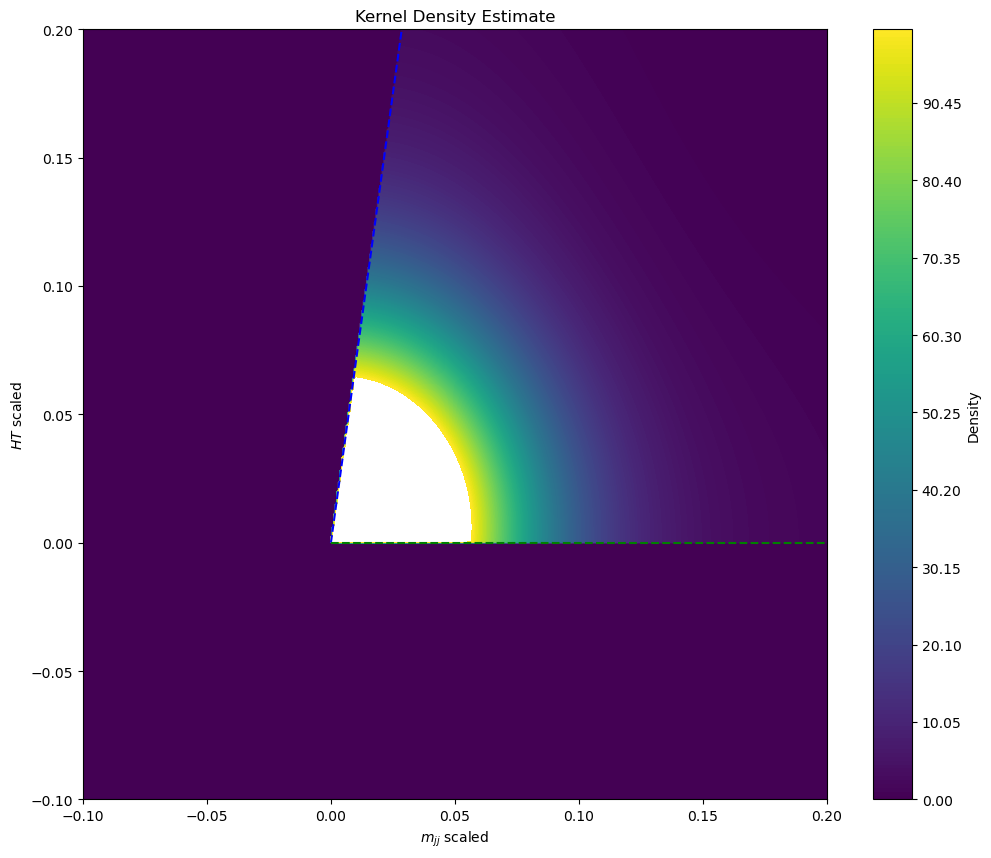

In [15]:
# 4. Plot the result
plt.figure(figsize=(12, 10))
plt.contourf(grids[0], grids[1], sum_grid, levels=np.linspace(level_min, level_max, 200), cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel(r"$m_{jj}$ scaled")
plt.ylabel(r"$HT$ scaled")
plt.title("Kernel Density Estimate")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)
plt.show()

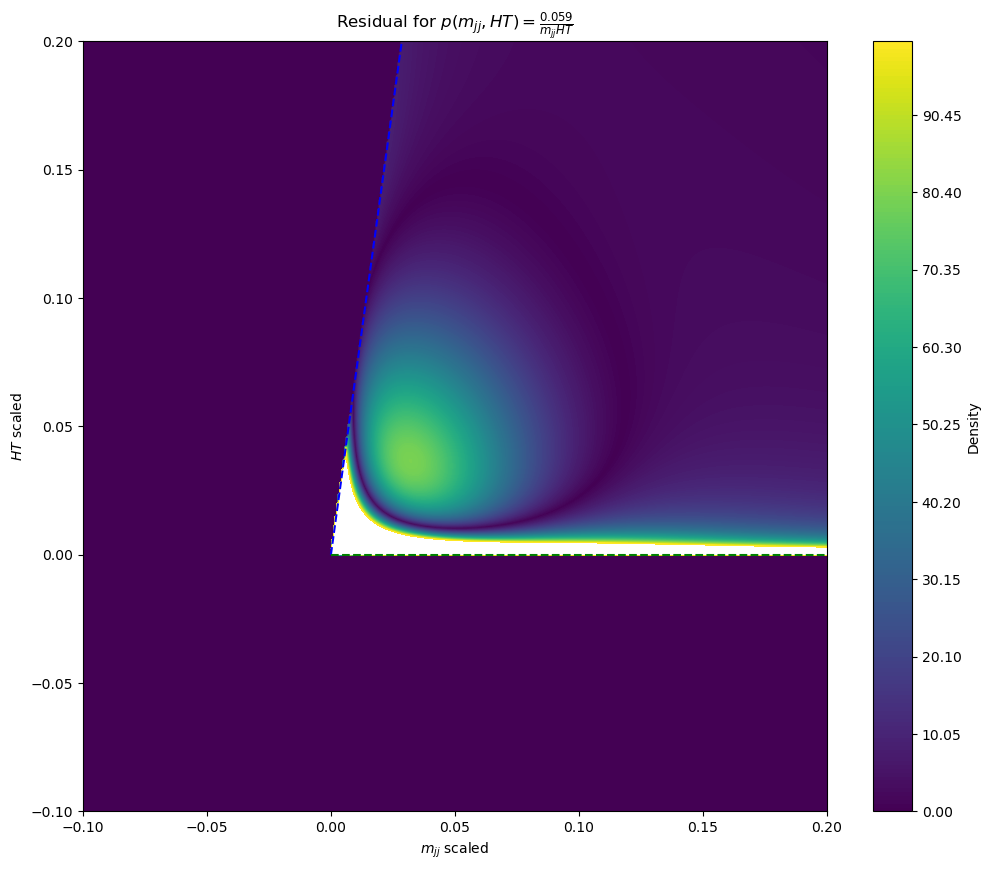

In [16]:
# 4. Plot the result
plt.figure(figsize=(12, 10))
plt.contourf(grids[0], grids[1], np.abs(sum_grid - res_func_complexity_5(grids[0], grids[1], ~mask)), levels=np.linspace(level_min, level_max, 200), cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel(r"$m_{jj}$ scaled")
plt.ylabel(r"$HT$ scaled")
plt.title(r"Residual for $p(m_{jj}, HT) = \frac{0.059}{m_{jj} HT}$")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)
plt.show()

/tmp/ipykernel_87816/832494956.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.where(mask, pow3(0.3686895696283121 / (x1 + x2)), 0)


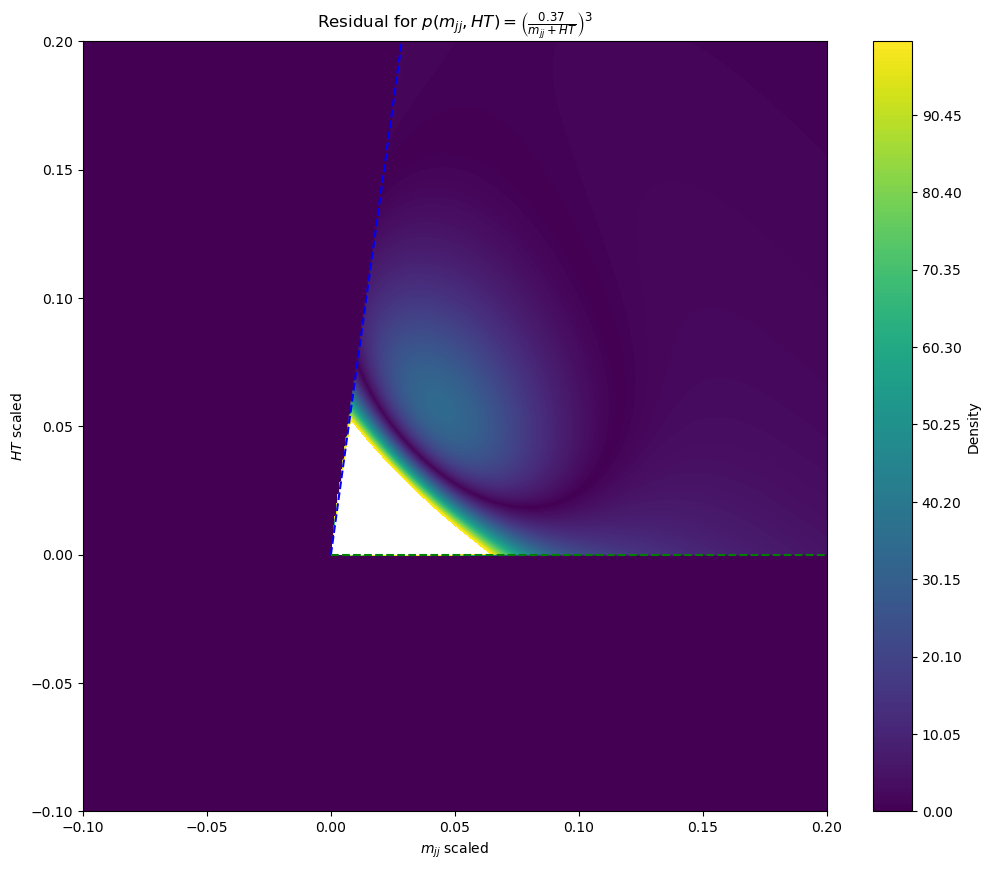

In [17]:
# 4. Plot the result
plt.figure(figsize=(12, 10))
plt.contourf(grids[0], grids[1], np.abs(sum_grid - res_func_complexity_6(grids[0], grids[1], ~mask)), levels=np.linspace(level_min, level_max, 200), cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel(r"$m_{jj}$ scaled")
plt.ylabel(r"$HT$ scaled")
plt.title(r"Residual for $p(m_{jj}, HT) = \left(\frac{0.37}{m_{jj} + HT}\right)^3$")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)
plt.show()

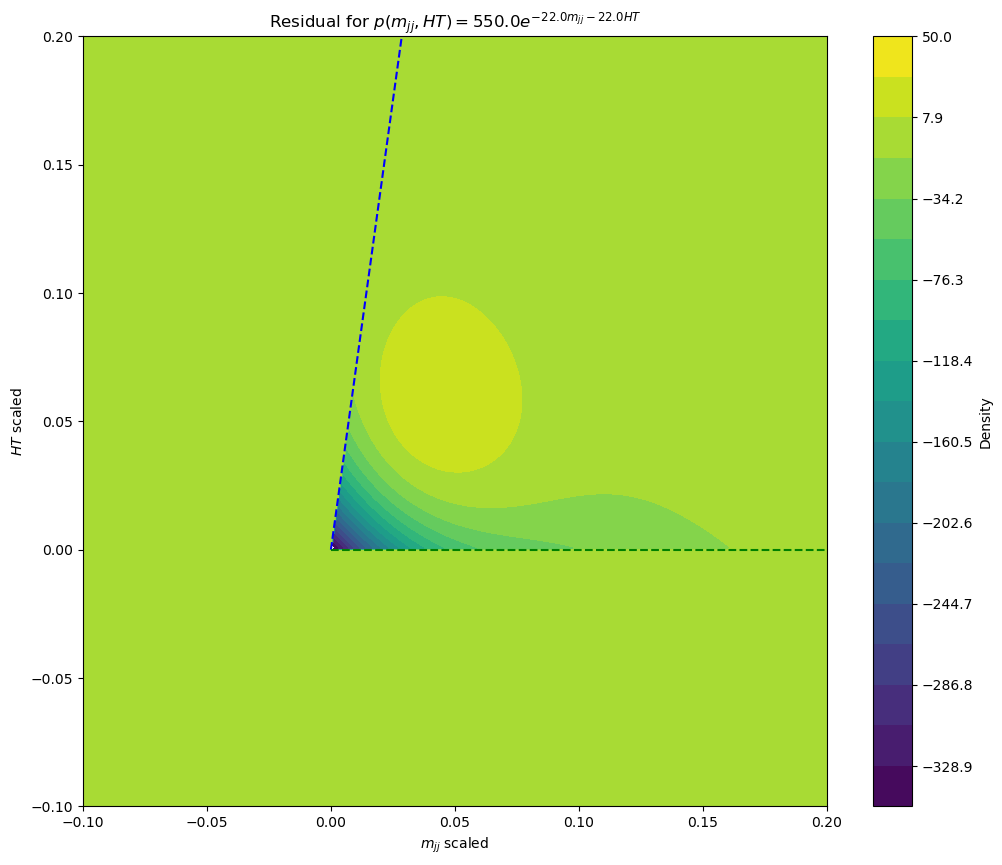

In [18]:
# 4. Plot the result
plt.figure(figsize=(12, 10))
plt.contourf(grids[0], grids[1], sum_grid - res_func_complexity_8(grids[0], grids[1], ~mask), levels=np.linspace(-350, 50, 20), cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel(r"$m_{jj}$ scaled")
plt.ylabel(r"$HT$ scaled")
plt.title(r"Residual for $p(m_{jj}, HT) = 550.0 e^{- 22.0 m_{jj} - 22.0 HT}$")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)
plt.show()

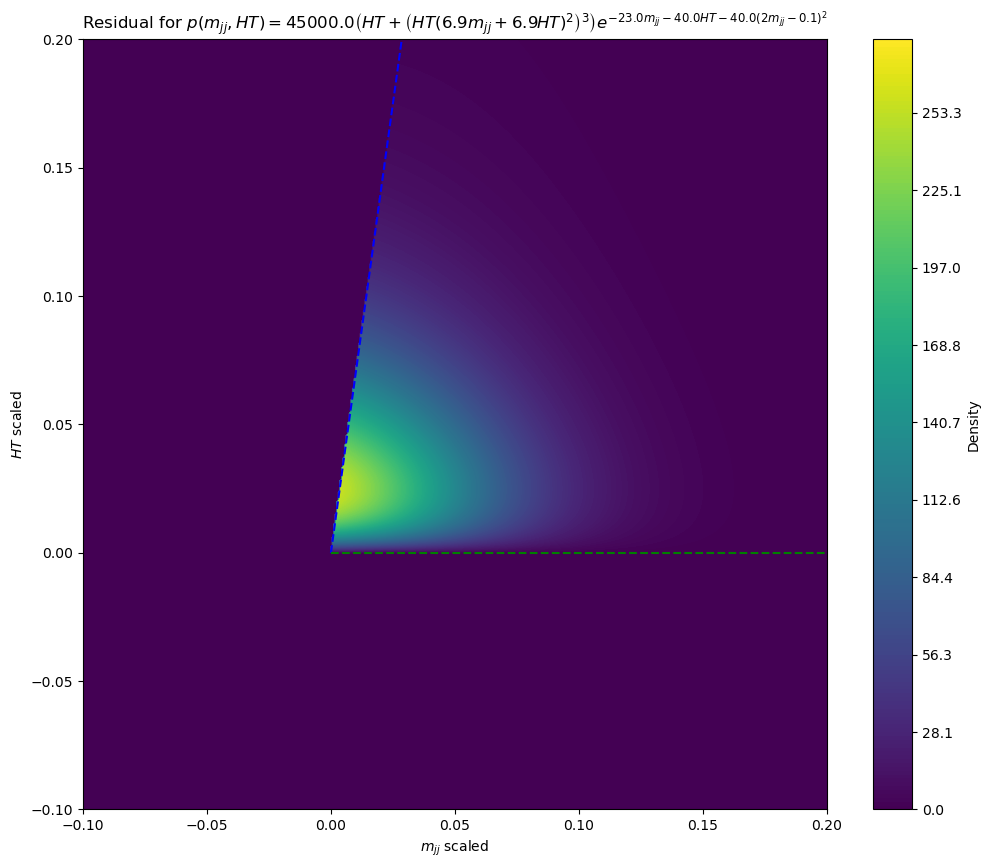

In [19]:
# 4. Plot the result
plt.figure(figsize=(12, 10))
plt.contourf(grids[0], grids[1], res_func_complexity_end(grids[0], grids[1], ~mask), levels=np.linspace(level_min, 280, 200), cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel(r"$m_{jj}$ scaled")
plt.ylabel(r"$HT$ scaled")
plt.title(r"Residual for $p(m_{jj}, HT) = 45000.0 \left(HT + \left(HT \left(6.9 m_{jj} + 6.9 HT \right)^2 \right)^3\right) e^{- 23.0 m_{jj} - 40.0 HT - 40.0 \left(2 m_{jj} - 0.1 \right)^2}$")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)
plt.show()

In [20]:
np.min(sum_grid - res_func_complexity_8(grids[0], grids[1], ~mask))

-371.1993732998927

In [21]:
print(f"min predict: {np.min(res_func_complexity_8(grids[0], grids[1], ~mask))}, max predict: {np.max(res_func_complexity_8(grids[0], grids[1], ~mask))}")

min predict: 0.0, max predict: 545.8125186755601


In [22]:
print(f"min kde: {np.min(sum_grid)}, max kde: {np.max(sum_grid)}")

min kde: 0.0, max kde: 178.1775917637152


Increase density of FFTKDE grid to better visualize residuals.
Play around with different colormaps and levels.